In [4]:
import argparse
import os
import pickle
import re
from pathlib import Path
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from skimage.util import img_as_ubyte

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#modules from movement
#load poses data
from movement.io import load_poses
from movement.io import save_poses

#Filter and interpolate related
from movement.filtering import filter_by_confidence, interpolate_over_time
import movement.kinematics as kin
from movement.filtering import (
    interpolate_over_time,
    median_filter,
    savgol_filter,
)
from movement.utils.vector import compute_norm

from matplotlib import pyplot as plt

from movement import sample_data
from movement.io import load_poses
from movement.io import load_bboxes

import xarray as xr
import scipy.signal 


In [2]:
ds_mouse = load_poses.from_sleap_file('Z://giocomo/esay/cd_project/behavior/videos/all_videos/h5/day1/day1_restrictwheel_0914.1.mp4.000_day1_restrictwheel_0914.1.analysis.h5', fps=30)


In [3]:
ds_mouse

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 18412, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, space, keypoints, individuals) float32 884kB 287.9 .....
    confidence   (time, keypoints, individuals) float32 442kB 0.9446 ... 0.6448
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/behavior/videos/all_videos/h...
    ds_type:          poses

In [8]:
ds_mouse.update({"position": filter_by_confidence(ds_mouse.position, ds_mouse.confidence, threshold=0.5)})



Missing points (marked as NaN) in input
	Individual: individual_0
		rightear: 836/18412 (4.5%)
		tailbase: 790/18412 (4.3%)
		nose: 1691/18412 (9.2%)
		head: 978/18412 (5.3%)
		leftear: 950/18412 (5.2%)
		torso: 499/18412 (2.7%)

Missing points (marked as NaN) in output
	Individual: individual_0
		rightear: 3255/18412 (17.7%)
		tailbase: 3182/18412 (17.3%)
		nose: 7663/18412 (41.6%)
		head: 3289/18412 (17.9%)
		leftear: 2580/18412 (14.0%)
		torso: 3447/18412 (18.7%)


<xarray.Dataset> Size: 1MB
Dimensions:      (time: 18412, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, space, keypoints, individuals) float32 884kB 287.9 .....
    confidence   (time, keypoints, individuals) float32 442kB 0.9446 ... 0.6448
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/behavior/videos/all_videos/h...
    ds_type:          poses

In [9]:
ds_mouse["speed"] = kin.compute_speed(ds_mouse.position)

In [10]:
'''
speed_threshold: @20250315, 1px ~ 0.06137 cm, so speed threshold is 200cm/s ~ 3259 px/s
'''
speed_threshold = 250

In [11]:
threshold = speed_threshold # based on the
speed_mouse_mask = ds_mouse["speed"] > threshold
expanded_mouse_mask = speed_mouse_mask
for i in range(len(speed_mouse_mask)):
    if speed_mouse_mask[i].any():
        expanded_mouse_mask[i-1] = True
            #expanded_mask[i] = True
            #if i<(len(speed_mouse_mask)-1):
            #    expanded_mouse_mask[i+1] = True
ds_mouse["position"] = xr.where(expanded_mouse_mask, np.nan, ds_mouse["position"])

In [12]:
ds_mouse

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 18412, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, keypoints, individuals, space) float32 884kB 287.9 .....
    confidence   (time, keypoints, individuals) float32 442kB 0.9446 ... 0.6448
    speed        (time, keypoints, individuals) float32 442kB 0.3205 ... 181.4
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/behavior/videos/all_videos/h...
    ds_type:          poses

In [16]:
ds_mouse.update({"position": interpolate_over_time(ds_mouse.position, max_gap=40)})



Missing points (marked as NaN) in input
	Individual: individual_0
		rightear: 3454/18412 (18.8%)
		tailbase: 3334/18412 (18.1%)
		nose: 7791/18412 (42.3%)
		head: 3439/18412 (18.7%)
		leftear: 2776/18412 (15.1%)
		torso: 3612/18412 (19.6%)

Missing points (marked as NaN) in output
	Individual: individual_0
		rightear: 1672/18412 (9.1%)
		tailbase: 1818/18412 (9.9%)
		nose: 4356/18412 (23.7%)
		head: 1773/18412 (9.6%)
		leftear: 1493/18412 (8.1%)
		torso: 1876/18412 (10.2%)


<xarray.Dataset> Size: 2MB
Dimensions:      (time: 18412, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, keypoints, individuals, space) float32 884kB 287.9 .....
    confidence   (time, keypoints, individuals) float32 442kB 0.9446 ... 0.6448
    speed        (time, keypoints, individuals) float32 442kB 0.3205 ... 181.4
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/behavior/videos/all_videos/h...
    ds_type:          poses

In [17]:
position = ds_mouse.position

In [18]:
da = position.sel(individuals="individual_0", method = "nearest")
print(da)

<xarray.DataArray 'position' (time: 18412, keypoints: 6, space: 2)> Size: 884kB
287.9 314.1 160.2 343.7 nan nan 279.9 296.2 ... nan nan nan nan nan 187.9 306.3
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
    individuals  <U12 48B 'individual_0'
Attributes:
    log:      [{'operation': 'interpolate_over_time', 'datetime': '2025-03-13...


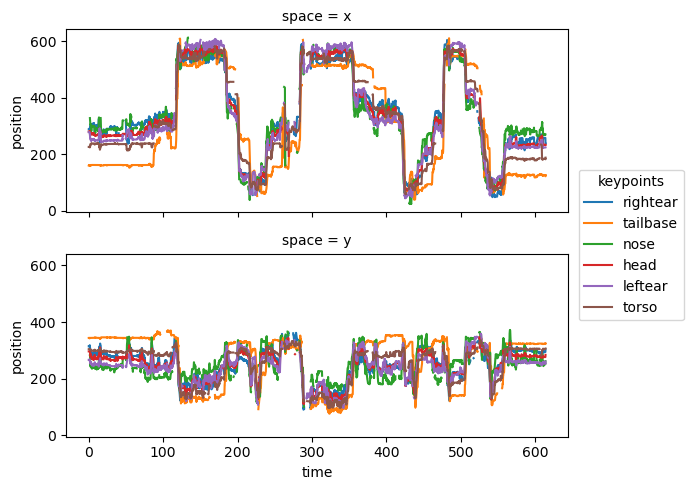

In [19]:
da.plot.line(x="time", row="space", aspect=2, size=2.5)


In [20]:
def plot_raw_and_smooth_timeseries_and_psd(
    ds_raw,
    ds_smooth,
    individual="individual_0",
    keypoint="head",
    space="x",
    time_range=None,
):
    # If no time range is specified, plot the entire time series
    if time_range is None:
        time_range = slice(0, ds_raw.time[-1])

    selection = {
        "time": time_range,
        "individuals": individual,
        "keypoints": keypoint,
        "space": space,
    }

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    for ds, color, label in zip(
        [ds_raw, ds_smooth], ["k", "r"], ["raw", "smooth"], strict=False
    ):
        # plot position time series
        pos = ds.position.sel(**selection)
        ax[0].plot(
            pos.time,
            pos,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

        # interpolate data to remove NaNs in the PSD calculation
        pos_interp = interpolate_over_time(
            pos, print_report=False, fill_value="extrapolate"
        )

        # compute and plot the PSD
        freq, psd = welch(pos_interp, fs=ds.fps, nperseg=256)
        ax[1].semilogy(
            freq,
            psd,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

    ax[0].set_ylabel(f"{space} position (px)")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Time Domain")
    ax[0].legend()

    ax[1].set_ylabel("PSD (px$^2$/Hz)")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_title("Frequency Domain")
    ax[1].legend()

    plt.tight_layout()
    fig.show()

In [21]:
window = int(0.1 * ds_mouse.fps)
ds_mouse_smooth = ds_mouse.copy()
ds_mouse_smooth.update({"position": median_filter(ds_mouse.position, window)})


Missing points (marked as NaN) in input
	Individual: individual_0
		rightear: 1672/18412 (9.1%)
		tailbase: 1818/18412 (9.9%)
		nose: 4356/18412 (23.7%)
		head: 1773/18412 (9.6%)
		leftear: 1493/18412 (8.1%)
		torso: 1876/18412 (10.2%)

Missing points (marked as NaN) in output
	Individual: individual_0
		rightear: 1708/18412 (9.3%)
		tailbase: 1850/18412 (10.0%)
		nose: 4450/18412 (24.2%)
		head: 1804/18412 (9.8%)
		leftear: 1527/18412 (8.3%)
		torso: 1914/18412 (10.4%)


<xarray.Dataset> Size: 2MB
Dimensions:      (time: 18412, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, keypoints, individuals, space) float32 884kB 287.9 .....
    confidence   (time, keypoints, individuals) float32 442kB 0.9446 ... 0.6448
    speed        (time, keypoints, individuals) float32 442kB 0.3205 ... 181.4
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/behavior/videos/all_videos/h...
    ds_type:          poses

In [22]:
from matplotlib import pyplot as plt
from scipy.signal import welch

from movement import sample_data
from movement.filtering import (
    interpolate_over_time,
    median_filter,
    savgol_filter,
)

C:\Users\esay\AppData\Local\Temp\ipykernel_109056\4185758196.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


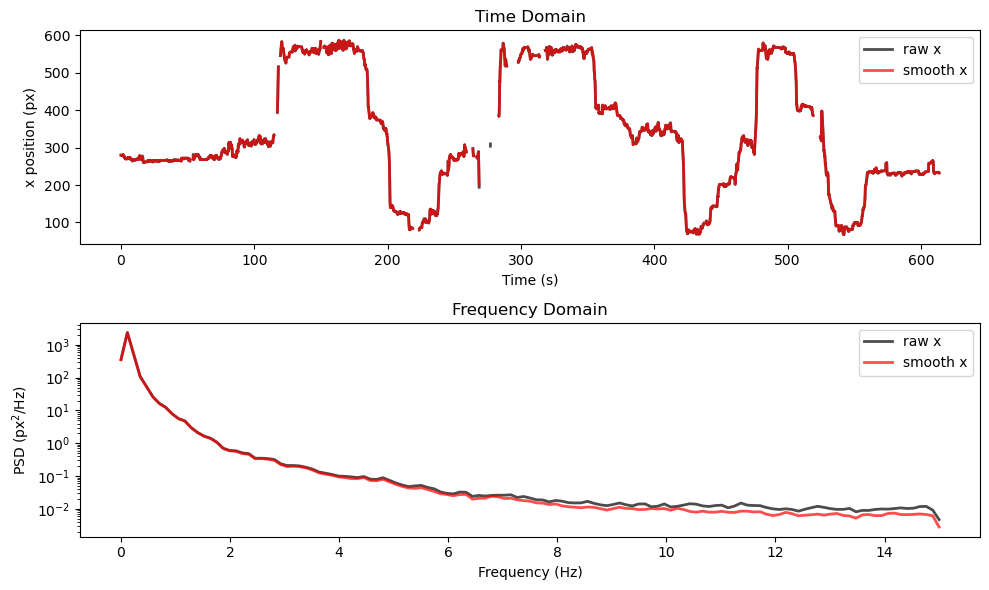

In [24]:
plot_raw_and_smooth_timeseries_and_psd(
    ds_mouse, ds_mouse_smooth, keypoint="head"
)

In [13]:
ds_mouse.keys()

KeysView(<xarray.Dataset> Size: 2MB
Dimensions:      (time: 18412, space: 2, keypoints: 6, individuals: 1)
Coordinates:
  * time         (time) float64 147kB 0.0 0.03333 0.06667 ... 613.6 613.7 613.7
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U8 192B 'rightear' 'tailbase' ... 'torso'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, keypoints, individuals, space) float32 884kB 287.9 .....
    confidence   (time, keypoints, individuals) float32 442kB 0.9446 ... 0.6448
    speed        (time, keypoints, individuals) float32 442kB 0.3205 ... 181.4
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      Z:/giocomo/esay/cd_project/behavior/videos/all_videos/h...
    ds_type:          poses)

In [26]:
# create heat map for time spent across frames 

all_x = np.concatenate((ds_mouse['head_x']).to_numpy())
all_y = np.concatenate(-(ds_mouse['head_y']).to_numpy())
# Create a 2D histogram
heatmap, xedges, yedges = np.histogram2d(all_x, all_y, bins=50)  # Adjust `bins` as needed
# Normalize the histogram to represent relative time spent
heatmap = heatmap / heatmap.sum()
# Plot the heatmap
plt.figure(figsize=(10, 7))
plt.imshow(
    heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='hot',
    aspect='auto'
)
plt.colorbar(label='Normalized Time Spent')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Day 4 Time Spent')
plt.show()

KeyError: "No variable named 'head_x'. Variables on the dataset include ['time', 'space', 'keypoints', 'individuals', 'position', 'confidence', 'speed']"